In [12]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


# Loss Function Declarations

In [15]:
def AE_MSE(data,pred):
    return torch.mean(torch.sum((data-pred)**2,dim=1))

def AE_MAE(data,pred):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))

def weighted_AE_MSE(data, pred):
    return torch.mean(torch.sum((data[:,0:48])**2,dim=1)*torch.sum((data-pred)**2,dim=1))

def dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def log_dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(torch.log((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))


def std_error(data,pred):
    return torch.mean(torch.sum(torch.abs(torch.subtract(data,pred)),dim=1))
def calcQ_Error(data,pred, mean,std):
    return torch.mean(torch.sum(torch.abs(pred-pred),dim=1))*std+mean
    
def new_loss(data,pred,epoch,cut = 50):
    #Reconstruction
    mse = AE_MSE(data,pred)
    if epoch < cut:
        return mse + std_error(data,pred) + calcQ_Error(data,pred,mean_dt_1,std_dt_1)
    else:
        #Energy Conservation
        sum_dt, sum_pred = torch.sum(data, dim=1), torch.sum(pred,dim=1)
        sum_error = torch.sum(torch.norm(sum_dt-sum_pred))
        

        return  mse +std_error(data,pred)+ calcQ_Error(data,pred,mean_dt_1,std_dt_1)+ sum_error*np.min([(epoch-cut)/cut,1])

# Dataloading and sorting by wafer type

In [5]:
n = 80

arr = torch.load('data/TTBAR/ttbar_1_greater_0_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'data/TTBAR/ttbar_{int(n+2)}_greater_0_sim')])



In [6]:
dt_1 = []
dt_2 = []
dt_3 = []

for a in arr:
    
    if a[-4].item() ==0.: 
        dt_1.append(a)
    elif a[-4].item() ==1.0: 
        dt_2.append(a)
    else:
        dt_3.append(a)
    
dt_1 = torch.vstack(dt_1).float()
dt_2 = torch.vstack(dt_2).float()   
dt_3 = torch.vstack(dt_3).float()   

In [7]:
mean_dt_1 = torch.mean(dt_1)
std_dt_1 = torch.std(dt_1)

Normalizing within each wafer by wafer_sum

In [8]:
wafer_sum = torch.sum(dt_1[:,0:48],dim=1)
AE_input = dt_1/torch.unsqueeze(wafer_sum,dim=1)



# Normalize input by wafer_sum, no normalization on AE ouput
Add sum of calcq to AE input, normalize by sum of calcq

In [9]:
dt_sum = torch.hstack([AE_input[:,0:48],torch.unsqueeze(wafer_sum,dim=1)])
AE_input = dt_sum


In [13]:

size_train =15000
size_test = 5000
train_loc = AE_input[0:size_train]
test_loc = AE_input[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=50,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=50,
    shuffle=False
)

train = AE_input[0:size_train,0:49]
test = AE_input[-size_test:,0:49]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=50,
    shuffle=False
)

test_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=50,
    shuffle=False
)

In [16]:
num_epochs = 100
lr = 0.0045
loss =new_loss

In [17]:
model = nn.Sequential(nn.Linear(49,250),
                      nn.ReLU(),
                      nn.Linear(250,100),
                      nn.ReLU(),
                      nn.Linear(100,16),
                      nn.ReLU(),
                      nn.Linear(16,100),
                      nn.ReLU(),
                      nn.Linear(100,250),
                      nn.ReLU(),
                      nn.Linear(250,48),
                      nn.ReLU())

Epoch 0, lr 0.0045
Epoch 0: Train 25.30697837193807, Test 24.954036712646484
Epoch 1, lr 0.0045
Epoch 1: Train 24.949514128367106, Test 24.93915367126465
Epoch 2, lr 0.0045
Epoch 2: Train 24.940456981658937, Test 24.93905258178711
Epoch 3, lr 0.0045
Epoch 3: Train 24.935485388437908, Test 24.928478240966797
Epoch 4, lr 0.0045
Epoch 4: Train 24.920573170979818, Test 24.913789749145508
Epoch 5, lr 0.0045
Epoch 5: Train 24.902225240071616, Test 24.890562057495117
Epoch 6, lr 0.0045
Epoch 6: Train 24.85634880065918, Test 24.820810317993164
Epoch 7, lr 0.0045
Epoch 7: Train 24.810545438130696, Test 24.790983200073242
Epoch 8, lr 0.0045
Epoch 8: Train 24.79233367284139, Test 24.77025604248047
Epoch 9, lr 0.0045
Epoch 9: Train 24.77448741912842, Test 24.766345977783203
Epoch 10, lr 0.0045
Epoch 10: Train 24.769771124521892, Test 24.756547927856445
Epoch 11, lr 0.0045
Epoch 11: Train 24.763928597768146, Test 24.75079345703125
Epoch 12, lr 0.0045
Epoch 12: Train 24.759212557474772, Test 24.7515

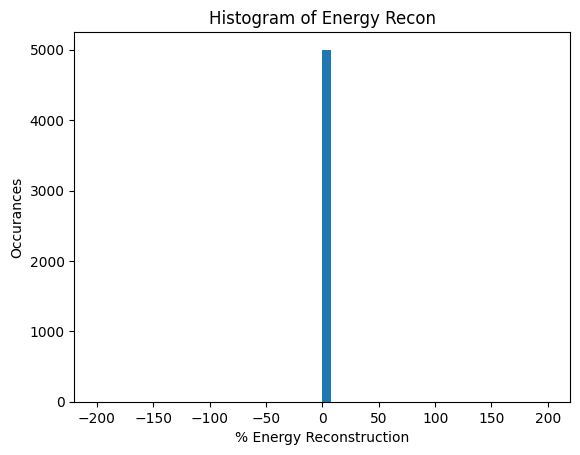

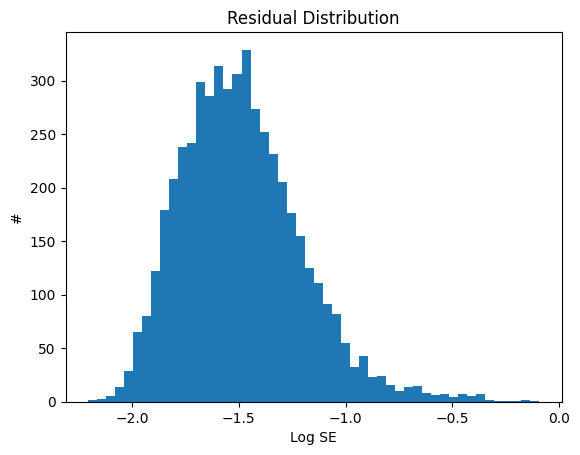

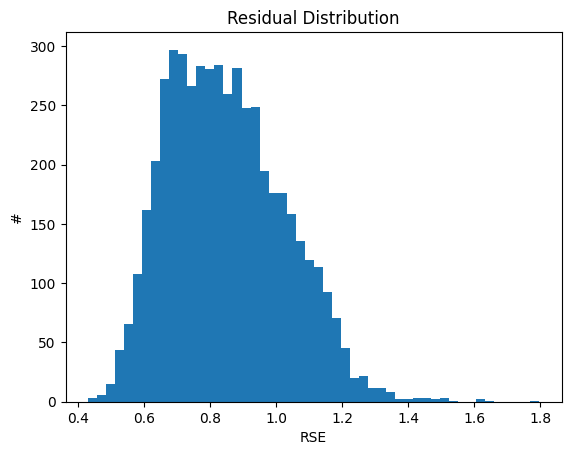

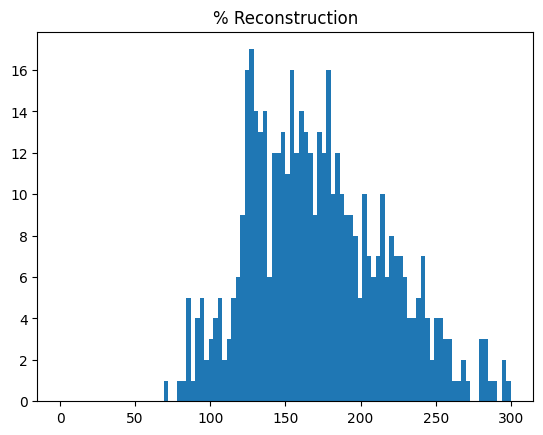

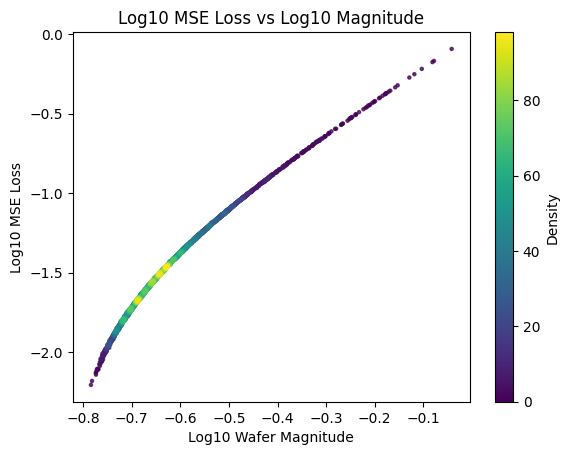

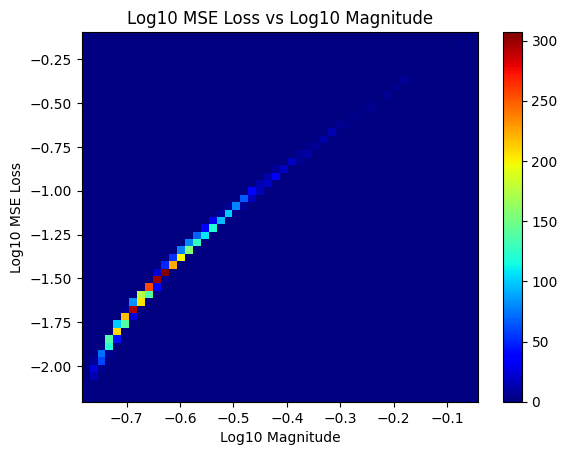

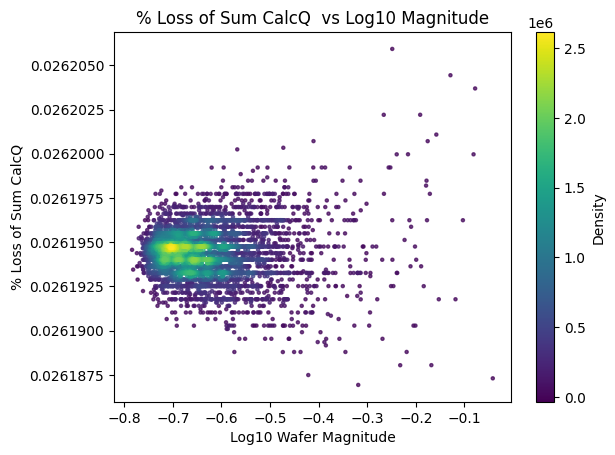

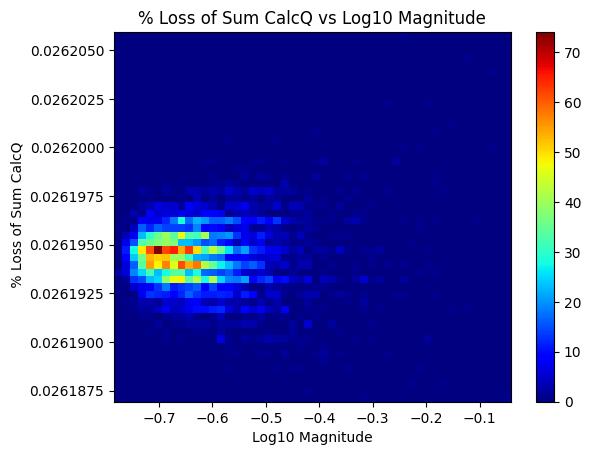

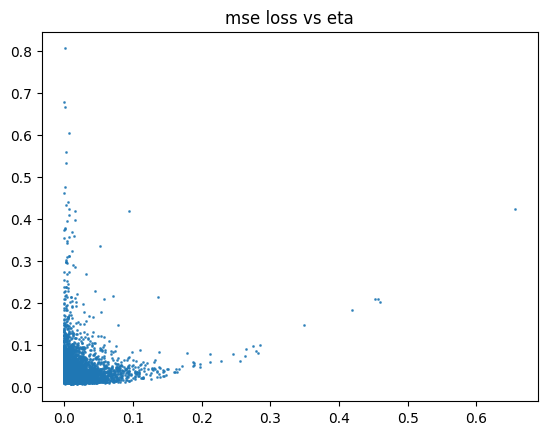

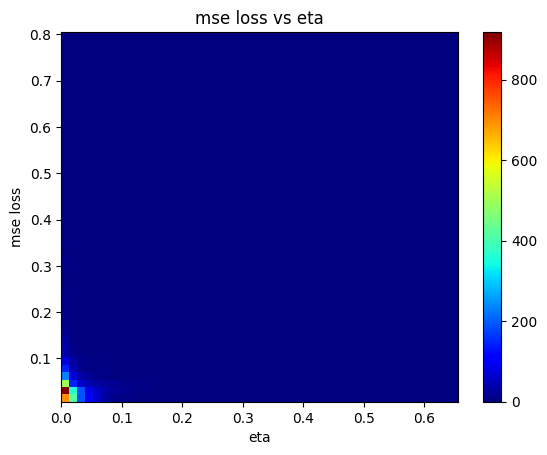

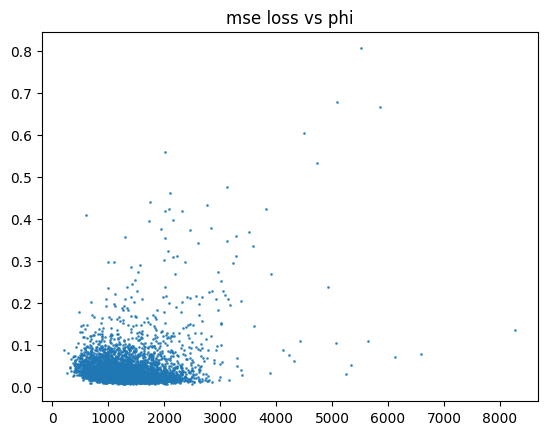

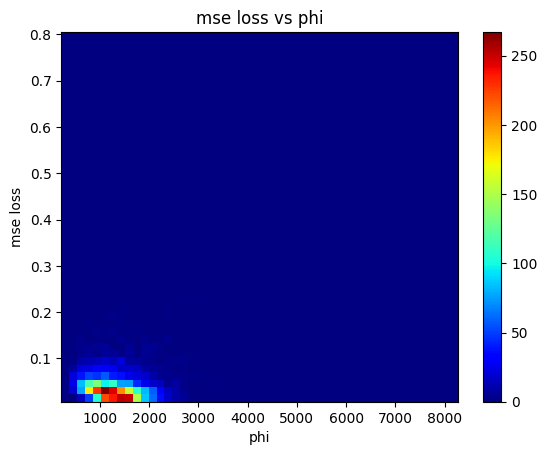

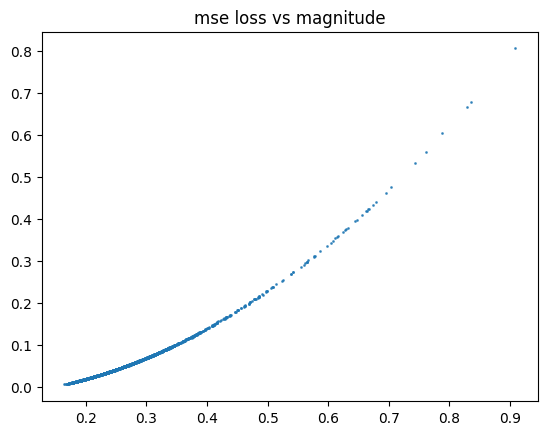

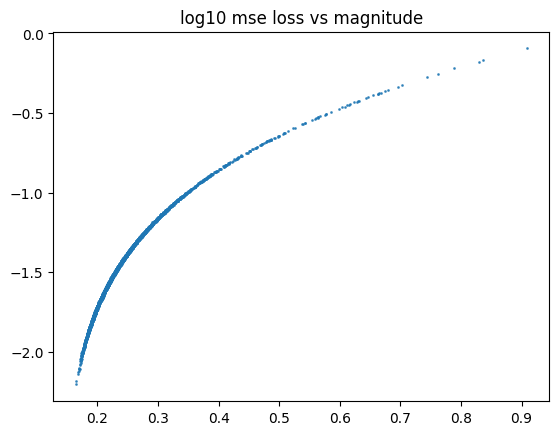

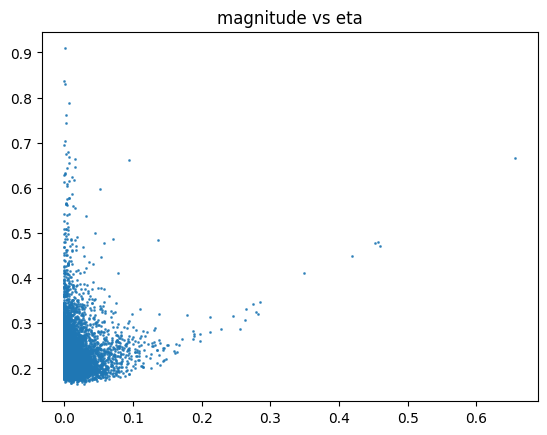

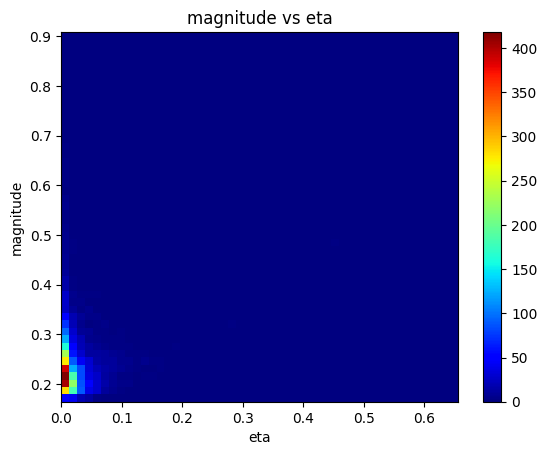

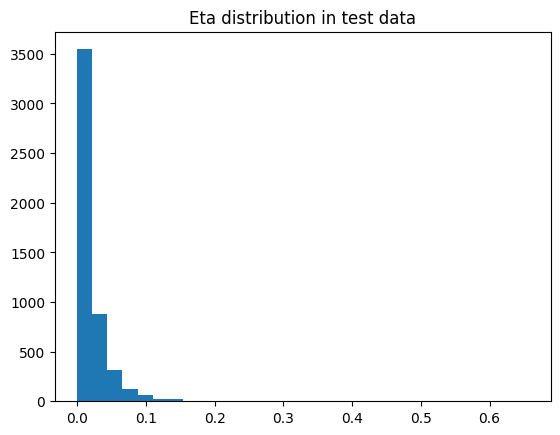

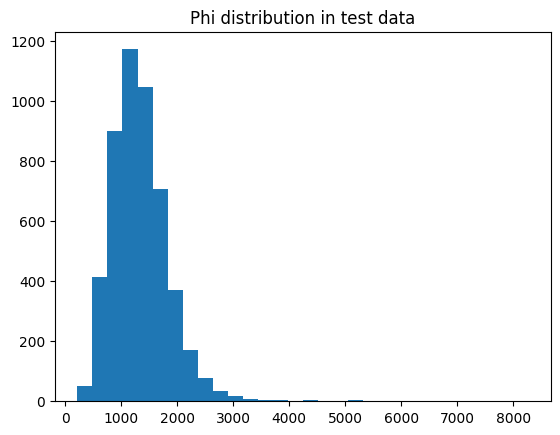

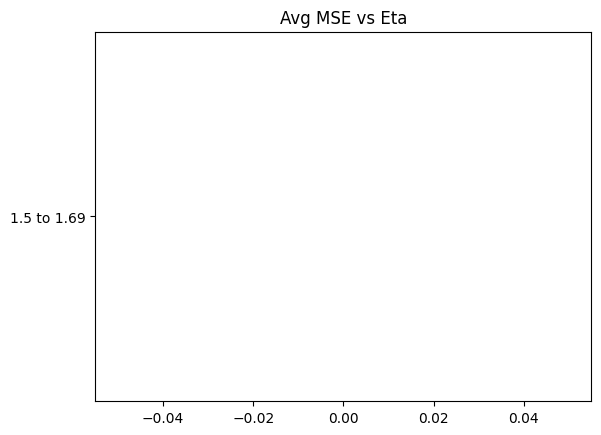

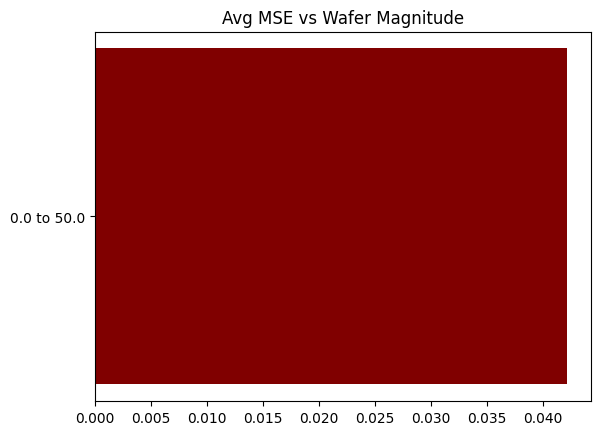

tensor([[2.8973e-02, 1.1390e+03, 2.7972e-01, 5.6962e-02, 8.6318e-01],
        [3.2814e-03, 1.2190e+03, 2.3566e-01, 3.4547e-02, 8.1307e-01],
        [0.0000e+00, 1.0900e+03, 2.9058e-01, 6.3701e-02, 8.7171e-01],
        ...,
        [1.1905e-02, 5.8800e+02, 2.9436e-01, 6.5382e-02, 1.1402e+00],
        [2.7650e-03, 1.0850e+03, 2.4233e-01, 3.7890e-02, 9.8279e-01],
        [7.5099e-02, 5.0600e+02, 2.5830e-01, 4.5521e-02, 1.1199e+00]],
       grad_fn=<CatBackward0>)

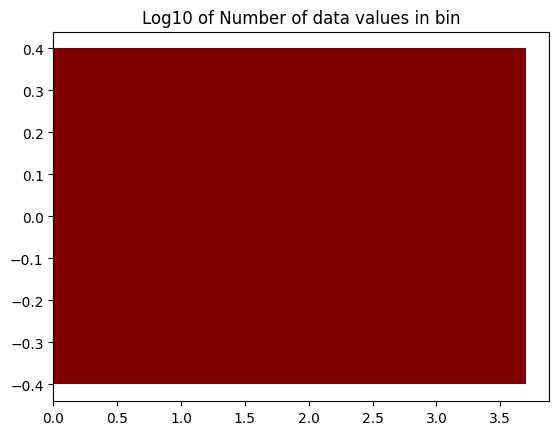

In [18]:
# fine-tune autoencoder
#batch 500
model_1 = model

test = AE_input[-size_test:,0:49]

optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_1.train()
        data = data_list[0]
        v_pred = model_1(data)
        
#         pred_sum = torch.unsqueeze(torch.sum(v_pred,dim=1),dim=1)
        
        batch_loss = loss(data[:,0:48], v_pred,epoch) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss)
    data_test = test
    model_1.eval()
    test_pred = model_1(data_test)
    batch_test = loss(data_test[:,0:48], test_pred,epoch)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_1.eval()

AE_Stats.gen_all_stats(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48],AE_input[-size_test:])


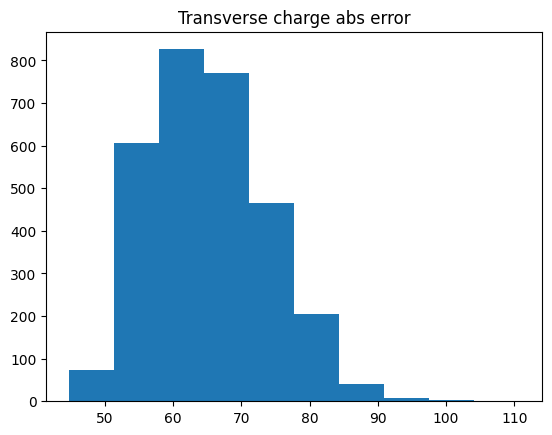

In [36]:
plt.title('Transverse charge abs error')
plt.hist((torch.sum(torch.abs(model_1(AE_input[-size_test:,0:49])-AE_input[-size_test:,0:48]),dim=1)*std_dt_1+mean_dt_1).detach().numpy())
plt.show()

In [37]:
print(f'New Loss total: {new_loss(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48],epoch =10000)}')
print(f'MSE: {AE_MSE(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48]).item()}')
print(f'Average of total wafer calcq error / std: {std_error(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48])}')
print(f'Average Error in transverse charge: {calcQ_Error(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48], mean_dt_1,std_dt_1)}')

New Loss total: 24.83521270751953
MSE: 0.0427970327436924
Average of total wafer calcq error / std: 0.8537030220031738
Average Error in transverse charge: 23.924360275268555


# Normalize input by wafer_sum, normalize on AE ouput by wafer_sum of output
wafer_sum = sum(wafer_values)

AE_input = wafer_values / wafer_sum

rawAE = AE(AE_input)

AE_output = rawAE / sum(rawAE)

loss = loss(AE_input, AE_output)

-----------------------------------------
We normalize the input and ouput of the AE by its sum. Calculate loss between normalized wafer input and ouput

In [21]:
def norm_by_wafer_sum(dt):
    sum_dt = torch.unsqueeze(torch.sum(dt,dim=1),dim=1)
    return dt/sum_dt

In [31]:
mod_sum = nn.Sequential(nn.Linear(49,250),
                      nn.ReLU(),
                      nn.Linear(250,100),
                      nn.ReLU(),
                      nn.Linear(100,16),
                      nn.ReLU(),
                      nn.Linear(16,100),
                      nn.ReLU(),
                      nn.Linear(100,250),
                      nn.ReLU(),
                      nn.Linear(250,48),
                      nn.ReLU())

In [32]:
size_train =10000
size_test = 3000
train_loc = AE_input[0:size_train]
test_loc = AE_input[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=50,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=50,
    shuffle=False
)

train = AE_input[0:size_train,0:49]
test = AE_input[-size_test:,0:49]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=50,
    shuffle=False
)

test_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=50,
    shuffle=False
)

Epoch 0, lr 0.0045
Epoch 0: Train 24.82235878944397, Test 24.823318481445312
Epoch 1, lr 0.0045
Epoch 1: Train 24.822137460708618, Test 24.823930740356445
Epoch 2, lr 0.0045
Epoch 2: Train 24.822121629714967, Test 24.82347297668457
Epoch 3, lr 0.0045
Epoch 3: Train 24.8221706867218, Test 24.823148727416992
Epoch 4, lr 0.0045
Epoch 4: Train 24.82217679977417, Test 24.823644638061523
Epoch 5, lr 0.0045
Epoch 5: Train 24.82214758872986, Test 24.823101043701172
Epoch 6, lr 0.0045
Epoch 6: Train 24.822189893722534, Test 24.82369041442871
Epoch 7, lr 0.0045
Epoch 7: Train 24.822174882888795, Test 24.823593139648438
Epoch 8, lr 0.0045
Epoch 8: Train 24.82216556549072, Test 24.82335090637207
Epoch 9, lr 0.0045
Epoch 9: Train 24.822174386978148, Test 24.823314666748047
Epoch 10, lr 0.0045
Epoch 10: Train 24.82222092628479, Test 24.82362174987793
Epoch 11, lr 0.00225
Epoch 11: Train 24.822132329940796, Test 24.824100494384766
Epoch 12, lr 0.00225
Epoch 12: Train 24.821313228607178, Test 24.82227

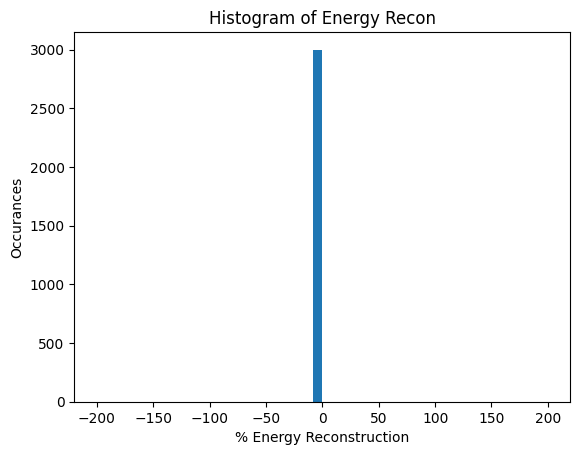

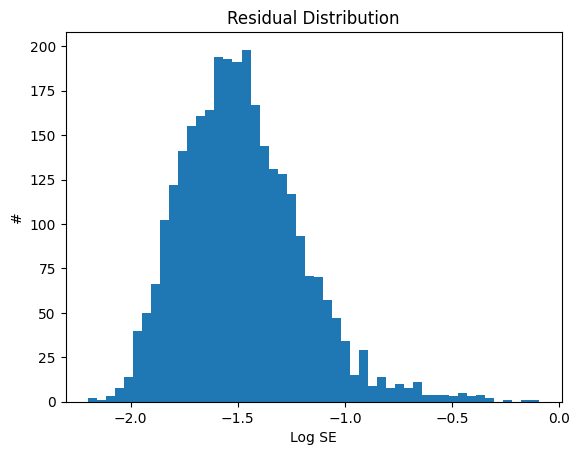

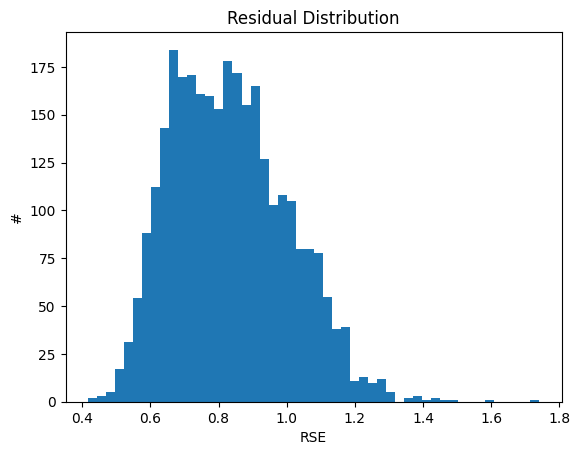

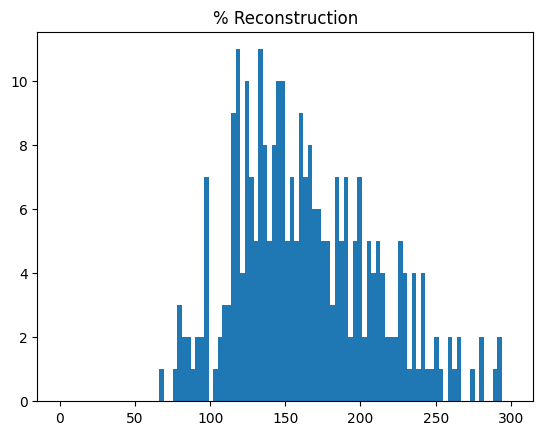

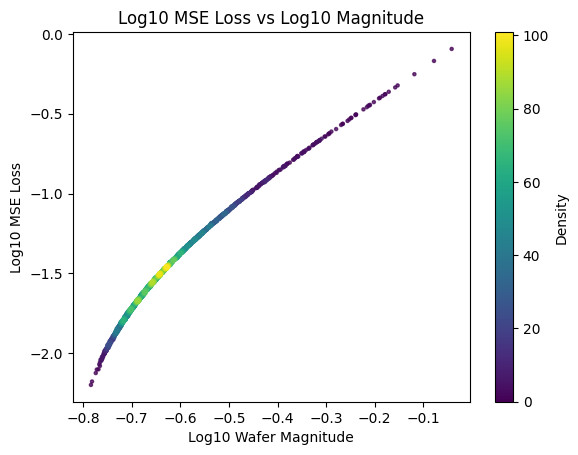

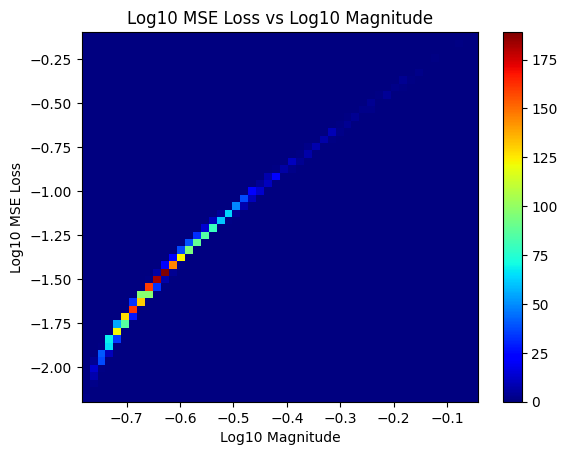

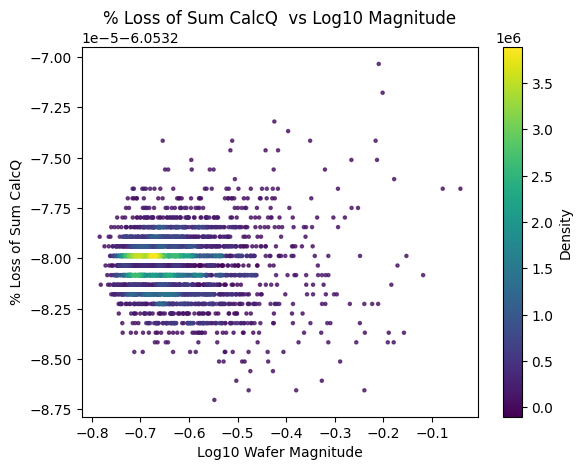

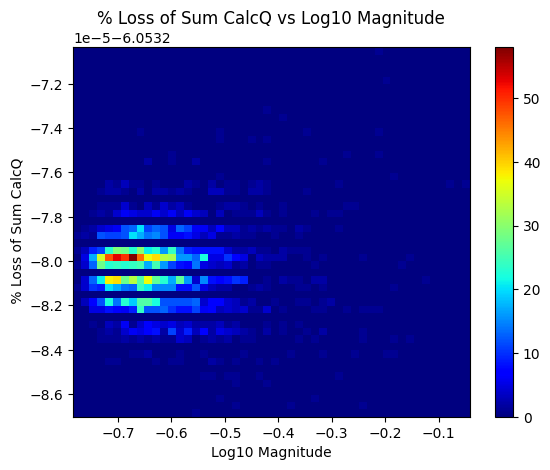

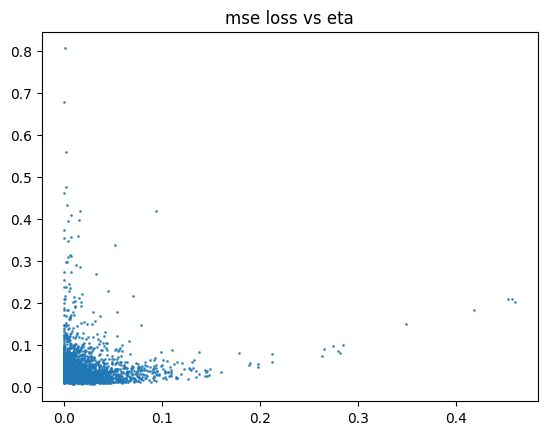

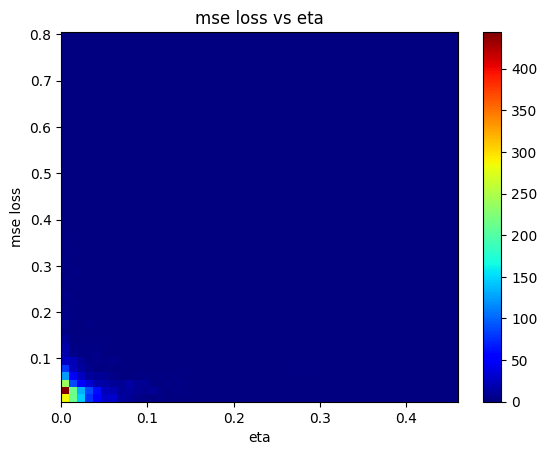

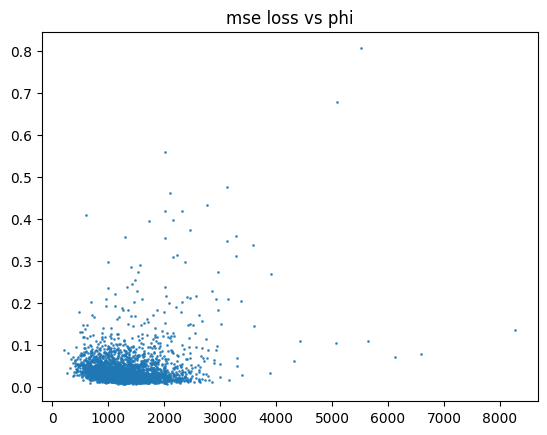

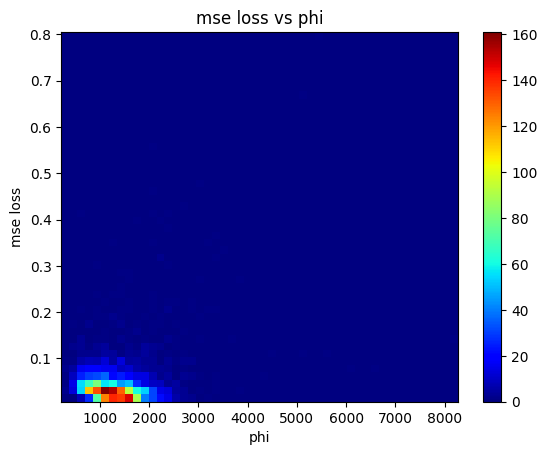

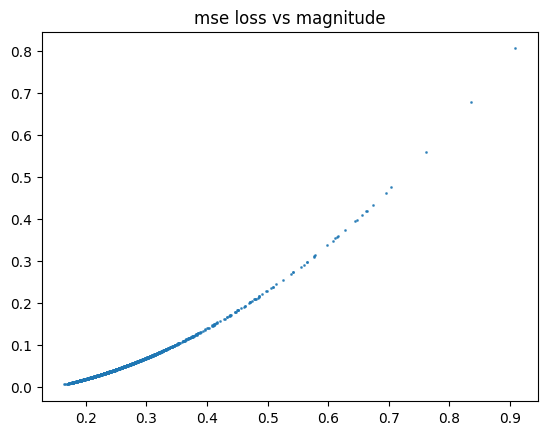

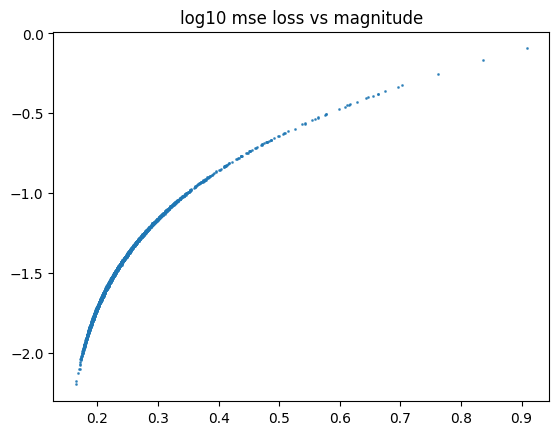

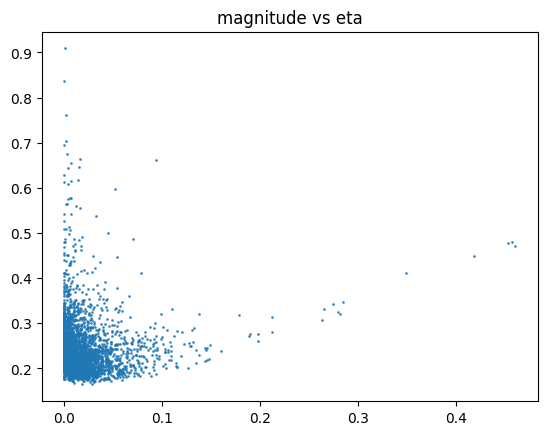

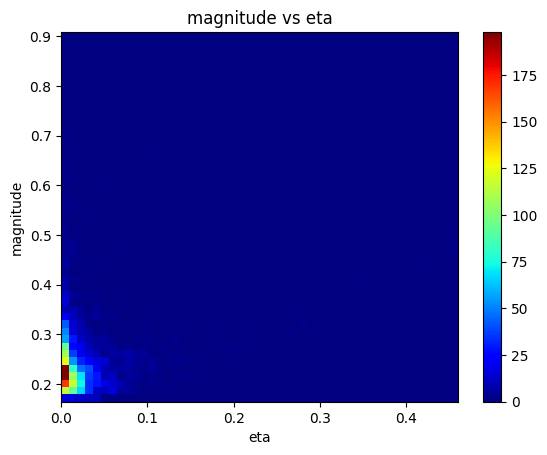

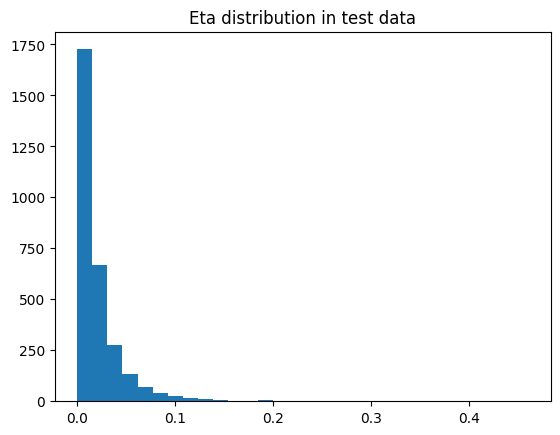

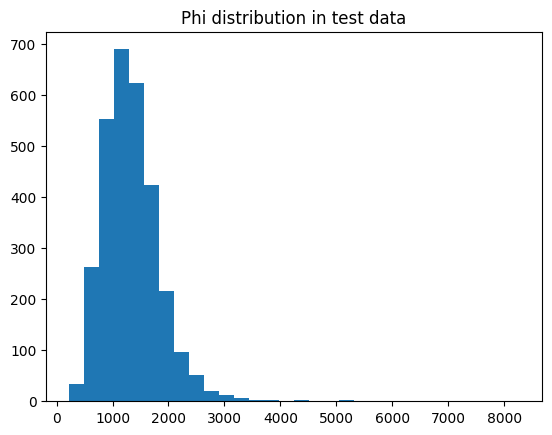

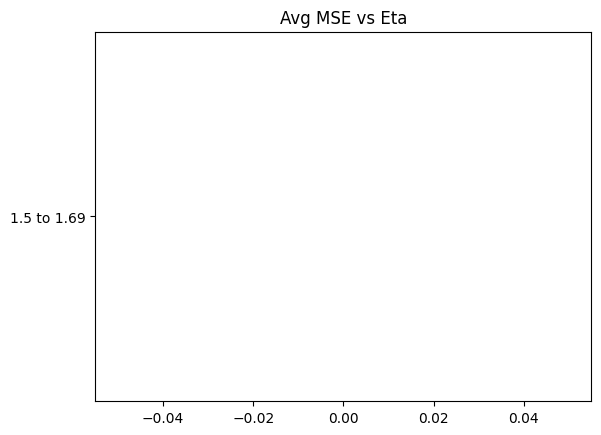

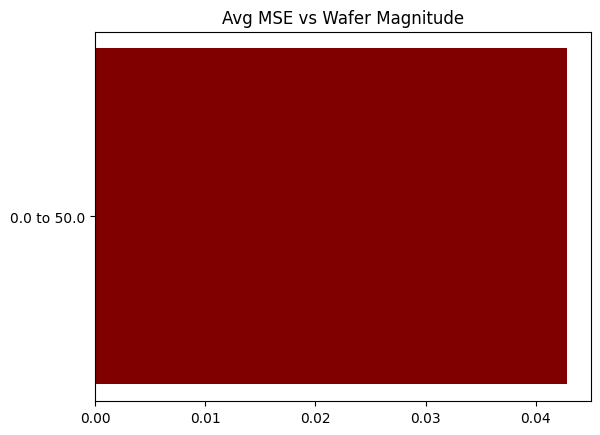

tensor([[3.1857e-02, 1.8520e+03, 1.8557e-01, 1.3794e-02, 6.0170e-01],
        [6.6622e-03, 1.5010e+03, 1.8122e-01, 1.2287e-02, 6.0894e-01],
        [4.6261e-03, 1.2970e+03, 2.0890e-01, 2.2745e-02, 6.8084e-01],
        ...,
        [1.1905e-02, 5.8800e+02, 2.9436e-01, 6.5567e-02, 1.1158e+00],
        [2.7650e-03, 1.0850e+03, 2.4233e-01, 3.7943e-02, 9.6235e-01],
        [7.5099e-02, 5.0600e+02, 2.5830e-01, 4.5605e-02, 1.0938e+00]],
       grad_fn=<CatBackward0>)

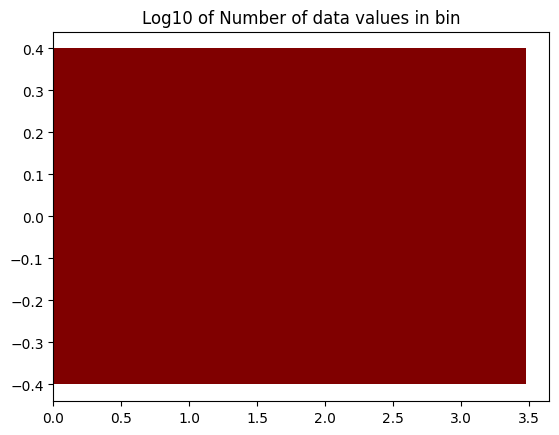

In [35]:
# fine-tune autoencoder
#batch 500
model_norm = mod_sum

test = AE_input[-size_test:,0:49]

optimizer = optim.Adam(model_norm.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_norm.train()
        data = data_list[0]
        v_pred = model_norm(data)
        

        batch_loss = loss(data[:,0:48], norm_by_wafer_sum(v_pred),epoch)  
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss)
    data_test = test
    model_norm.eval()
    test_pred = model_norm(data_test)
    batch_test = loss(data_test[:,0:48], norm_by_wafer_sum(test_pred),epoch)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_norm.eval()

AE_Stats.gen_all_stats(model_norm(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48],AE_input[-size_test:])


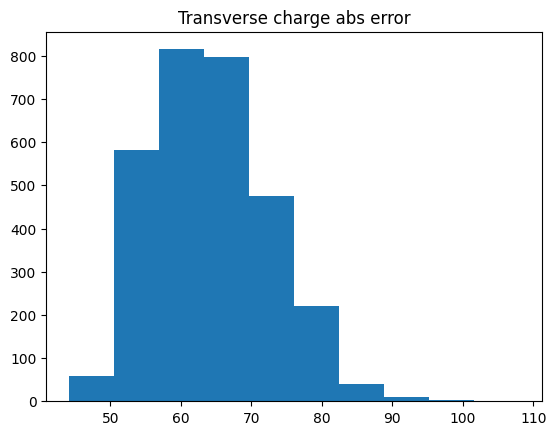

In [40]:
plt.title('Transverse charge abs error')
plt.hist((torch.sum(torch.abs(model_norm(AE_input[-size_test:,0:49])-AE_input[-size_test:,0:48]),dim=1)*std_dt_1+mean_dt_1).detach().numpy())
plt.show()

In [41]:
print(f'New Loss total: {new_loss(model_norm(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48],epoch =10000)}')
print(f'MSE: {AE_MSE(model_norm(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48]).item()}')
print(f'Average of total wafer calcq error / std: {std_error(model_norm(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48])}')
print(f'Average Error in transverse charge: {calcQ_Error(model_norm(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48], mean_dt_1,std_dt_1)}')

New Loss total: 28.116294860839844
MSE: 0.042872197926044464
Average of total wafer calcq error / std: 0.8335433602333069
Average Error in transverse charge: 23.924360275268555
